In [135]:
%load_ext autoreload
%autoreload 2
from plot import *
import os
import sys

sys.path.append(os.path.abspath('../'))
from analysis_util import *

from norm import read_norm_data
from sgd_weights import sgd_weights


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [136]:
# results_path = '../../results/bloat-then-min-prune/conditions/bloat-then-min-prune-64-0/run_18245290851331019246'
results_path = '../../results/bloat-prune/conditions/64-0/run_18245290851331019246'
# results_path = '../../results/bloat-prune/conditions/16-16/run_169547195123044846'
# results_path = '../../results/bloat-prune/conditions/64-64/run_1274002656662721006'

In [137]:
os.makedirs(os.path.join(results_path,'figures'), exist_ok=True)

In [138]:
genomes_by_batch, config = get_cppns_by_batch(results_path, 10)

  0%|          | 0/41 [00:00<?, ?it/s]

 12%|█▏        | 5/41 [00:01<00:09,  3.79it/s]


Loaded 5 genomes


In [139]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
inputs = load_inputs(results_path, device)
target = load_target(results_path, config)
norm = read_norm_data(os.path.join("../", config.norm_df_path), config.target_name)
   
print(inputs.shape)

torch.Size([128, 128, 131])


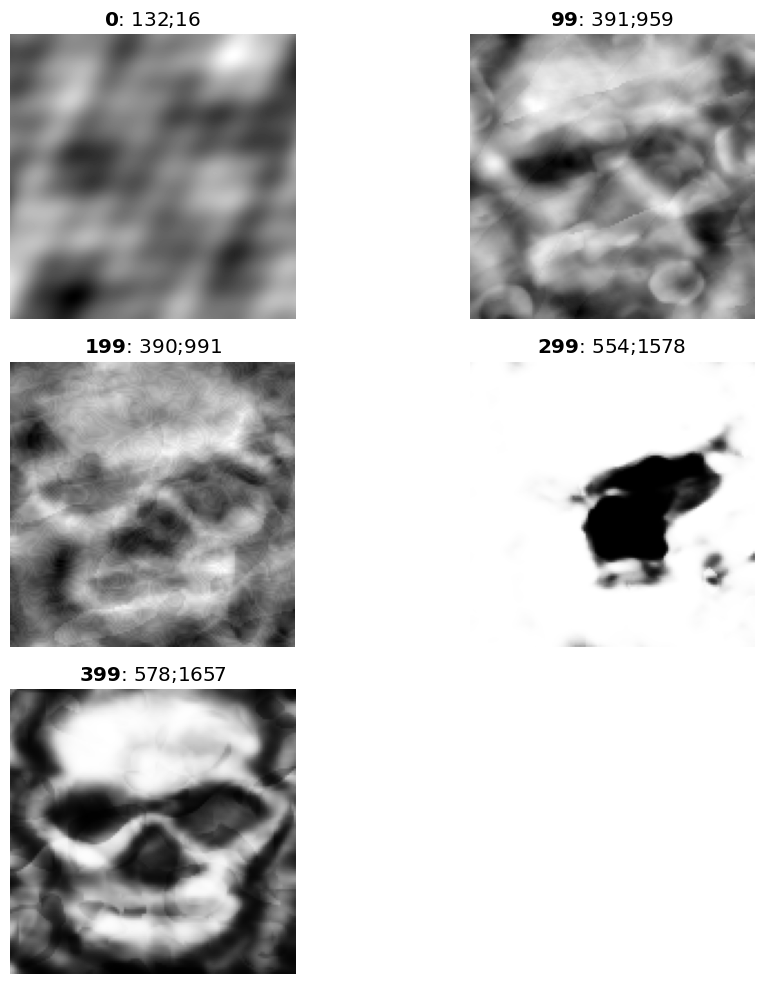

In [140]:
show_img_progression(genomes_by_batch, inputs, os.path.join(results_path,'progression.png'))

In [141]:
import torch

num_steps = 500
config.sgd_steps = num_steps

def get_sgd_loss(cppn):
    losses = torch.zeros(num_steps)
    sgd_weights([cppn], None, inputs, target, config.objective_functions, norm, config, None, losses)
    return losses

In [142]:
all_losses_unmutated = torch.ones(len(genomes_by_batch), num_steps) * -torch.inf
for index, (batch, cppn) in enumerate(genomes_by_batch.items()):
    all_losses_unmutated[index] = get_sgd_loss(cppn)
        

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

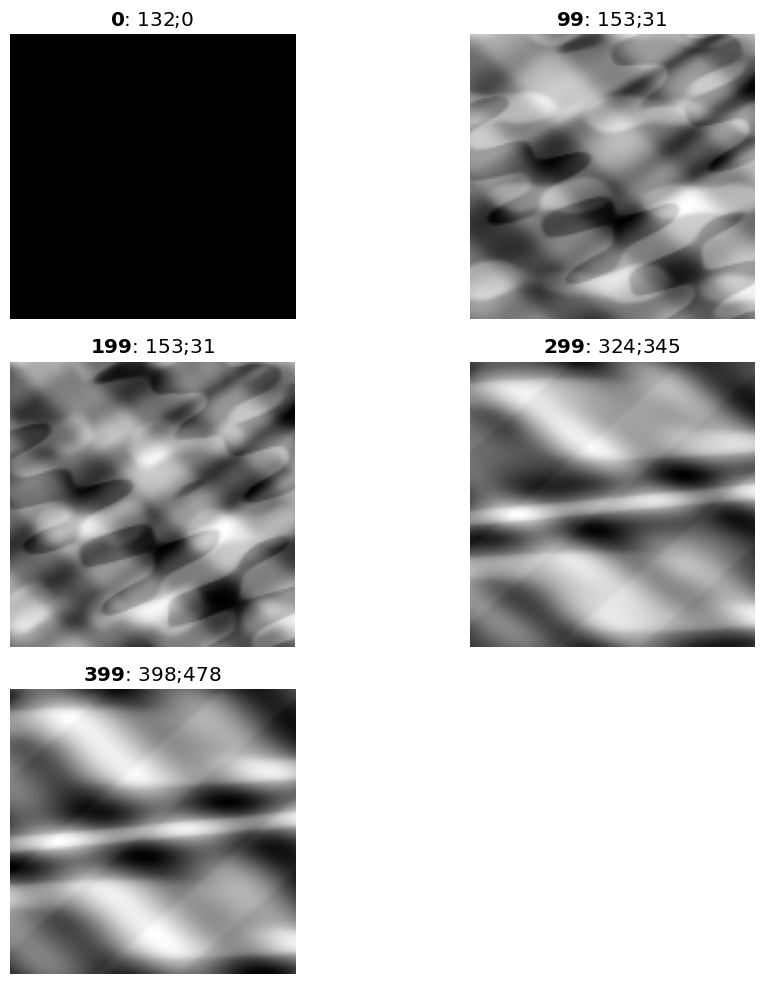

In [ ]:
show_img_progression(genomes_by_batch, inputs, os.path.join(results_path,'figures/progression_sgd.png'))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_sgd_loss(losses, title, save_name):
    sns.set_style("darkgrid")
    sns.set_context("paper")
    sns.lineplot(data=losses.T, dashes=False, legend='full')
    # change legend to batch from index
    plt.legend(title='Batch')
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.gca().legend(handles=handles, labels=list(genomes_by_batch.keys()), title='Batch')
    plt.xlabel('SGD step')
    plt.ylabel('Loss')
    plt.title(title)
    if save_name is not None:
        save_path = os.path.join(results_path, save_name)
        plt.savefig(save_path)
    plt.show()

import warnings
warnings.filterwarnings('ignore', 'FutureWarning: is_categorical_dtype is deprecated') # ignore warning about seaborn

/home/jackson/miniconda3/envs/move/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jackson/miniconda3/envs/move/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jackson/miniconda3/envs/move/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jackson/miniconda3/envs/move/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

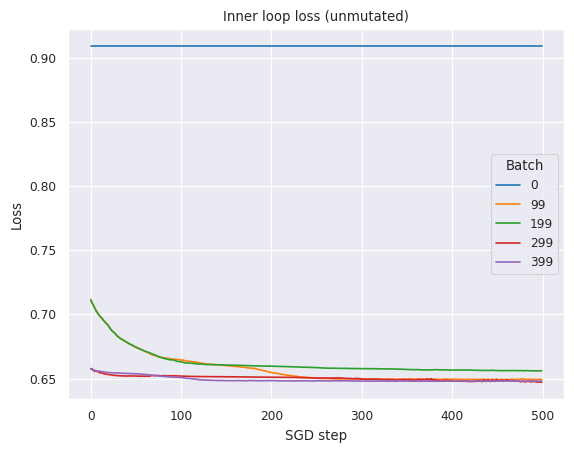

In [ ]:
plot_sgd_loss(all_losses_unmutated, 'Inner loop loss (unmutated)', 'figures/sgd_loss_unmutated.png')

In [143]:
all_losses_mutated = torch.ones(len(genomes_by_batch), num_steps) * -torch.inf
mutated_cppns = {}
set_max_node_id(genomes_by_batch)
muts = 10
for index, (batch, cppn) in enumerate(genomes_by_batch.items()):
    cppn_mutated = cppn.clone(config)
    trials = []
    for _ in range(muts):
        cppn_mutated.mutate(config)
        mutated_cppns[batch] = cppn_mutated
        trials.append(get_sgd_loss(cppn_mutated))
    all_losses_mutated[index] = torch.stack(trials).mean(dim=0)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

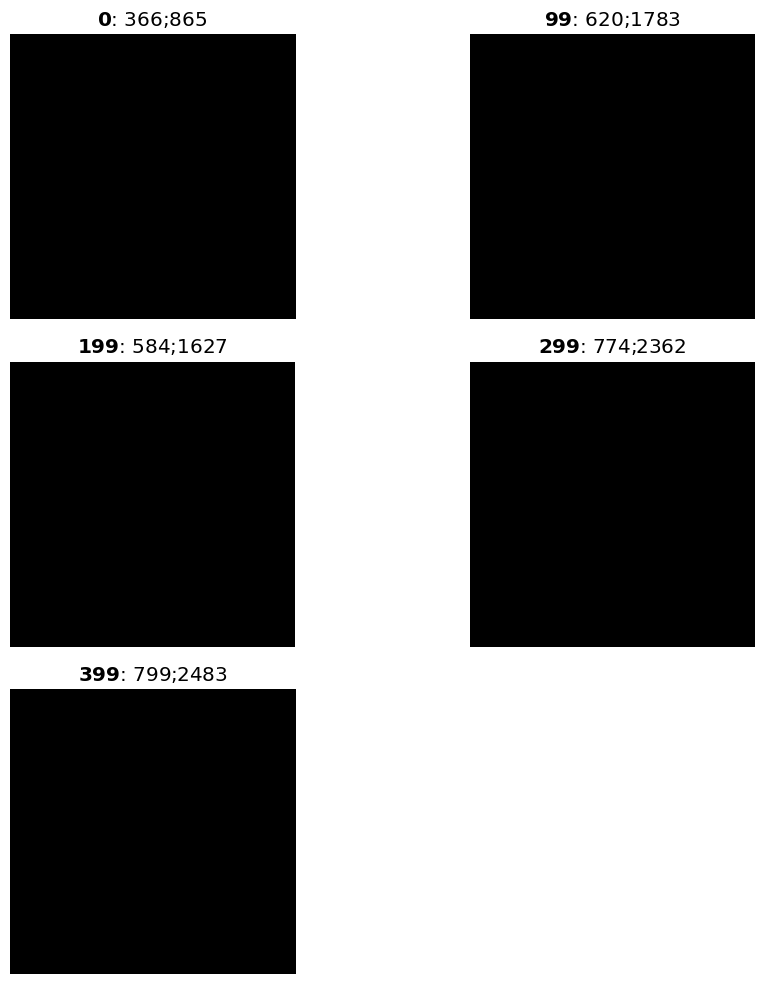

In [144]:
show_img_progression(mutated_cppns, inputs, os.path.join(results_path,'figures/progression_mutated.png'))


/home/jackson/miniconda3/envs/move/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jackson/miniconda3/envs/move/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jackson/miniconda3/envs/move/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jackson/miniconda3/envs/move/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

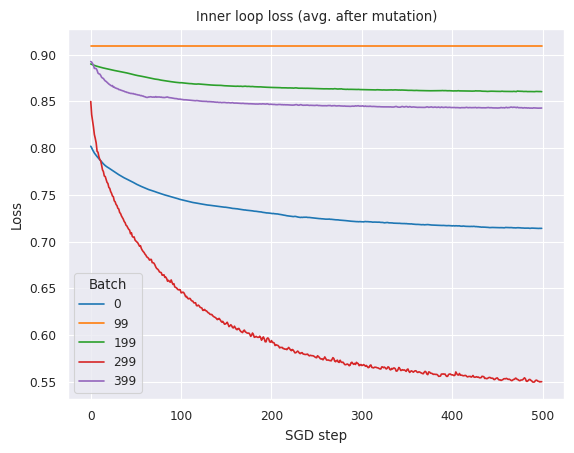

In [145]:
plot_sgd_loss(all_losses_mutated, 'Inner loop loss (avg. after mutation)' , 'figures/sgd_loss_mutated.png')